In [1]:
import numpy as np
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score 

####  Piecewise function：
$$y=\begin{cases}
2 + 3x_1 + 4x_2 + 20x_1x_2 & 0 \leq x_1 < 0.5, 0 \leq x_2 < 0.5 \\
2 + 3x_1 + 4x_2 - 10x_1x_2 & 0 \leq x_1 < 0.5, 0.5 \leq x_2 < 1 \\
2 + 3x_1 + 4x_2 + 10x_1x_2 & 0.5 \leq x_1 < 1, 0 \leq x_2 < 0.5 \\
2 + 3x_1 + 4x_2 - 5x_1x_2 & 0.5 \leq x_1 < 1, 0.5 \leq x_2 < 1
\end{cases}$$

In [2]:
# Create dataset
np.random.seed(42)
X = np.random.rand(50000, 2)

def myfun(x):
    
    if 0 <= x[0] and x[0] < 0.5 and 0 <= x[1] and x[1] < 0.5:
        y = 2 + 3 * x[0] + 4 * x[1] + 20 * x[0] * x[1]  
        
    elif 0 <= x[0] and x[0] < 0.5 and 0.5 <= x[1] and x[1] < 1:
        y = 2 + 3 * x[0] + 4 * x[1] - 10 * x[0] * x[1] 
    
    elif 0.5 <= x[0] and x[0] < 1 and 0 <= x[1] and x[1] < 0.5:
        y = 2 + 3 * x[0] + 4 * x[1] + 10 * x[0] * x[1]  
    
    else:
        y = 2 + 3 * x[0] + 4 * x[1] - 5 * x[0] * x[1]  
        
    return y

y = np.apply_along_axis(myfun, 1, X) + np.random.randn(50000)

In [3]:
# Get the interaction term of x_1 times x_2
X_inter = X[:,0] * X[:,1]
X = np.concatenate((X, X_inter.reshape(-1,1)), axis=1)

X_train, X_eval, X_test = X[:35000], X[35000:45000], X[45000:]
y_train, y_eval, y_test = y[:35000], y[35000:45000], y[45000:]

In [4]:
X[:5]

array([[0.37454012, 0.95071431, 0.35608065],
       [0.73199394, 0.59865848, 0.43821438],
       [0.15601864, 0.15599452, 0.02433805],
       [0.05808361, 0.86617615, 0.05031064],
       [0.60111501, 0.70807258, 0.42563306]])

In [5]:
y[:5]

array([4.20838218, 6.92343086, 3.47866357, 2.93824463, 5.93281742])

# $M_{Linear}$: 
### Linear regression model with three input variables, $x_1$, $x_2$ and $x_1x_2$

In [6]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
lin_reg.intercept_, lin_reg.coef_

(2.992162141243706, array([ 5.64233603,  1.72220449, -6.28848671]))

In [7]:
pred = lin_reg.predict(X_test)
print("Linear regression model result:")
print("R2 = {:.4f}".format(r2_score(y_test, pred)), "MSE = {:.4f}".format(mean_squared_error(y_test, pred)))

Linear regression model result:
R2 = 0.2286 MSE = 3.2427


# $M_{Neural2}$:
### Three-layer neural network with two input variables, $x_1$ and $x_2$ 

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim


class NN3(nn.Module):
    
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        
        super(NN3, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(in_dim, n_hidden_1),
            nn.Tanh(),
            nn.Linear(n_hidden_1, n_hidden_2), 
            nn.Tanh(),
            nn.Linear(n_hidden_2, out_dim)
        )

    def forward(self, x):

        x = self.net(x)

        return x

In [10]:
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# input : x_1, x_2
model = NN3(2, 8, 4, 1)
optimizer = optim.Adam(model.parameters(), lr=0.005)
loss_fun = nn.MSELoss()

In [11]:
def compute_val(X, y):
    inputs, labels = torch.tensor(X[:,:2], dtype=torch.float), torch.tensor(y, dtype=torch.float).reshape(-1,1)
    model.eval()
    outputs = model(inputs)
    pred = outputs.detach().numpy()
    mse = mean_squared_error(y, pred)
    r2 = r2_score(y, pred)
    return mse, r2

inputs, labels = torch.tensor(X_train[:,:2], dtype=torch.float), torch.tensor(y_train, dtype=torch.float).reshape(-1,1)

model.train()
best_eval = np.inf
bad_counter = 0
for epoch in range(40000):
    
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_fun(outputs, labels)
    loss.backward()
    optimizer.step()
    
    eval_mse, eval_r2 = compute_val(X_eval, y_eval)
    test_mse, test_r2 = compute_val(X_test, y_test)
    
    if eval_mse < best_eval:
        best_eval = eval_mse
        best_test_mse = test_mse
        best_test_r2 = test_r2
        bad_counter = 0
        
    else:
        bad_counter += 1
        
    if bad_counter == 50:
        break
    
    if epoch % 50 == 0:
        print("epoch = {}".format(epoch), "loss = {:.4f}".format(loss.item()),
             "eval_mse = {:.4f}".format(eval_mse), "test_mse = {:.4f}".format(test_mse))

epoch = 0 loss = 29.8230 eval_mse = 29.5404 test_mse = 29.2464
epoch = 50 loss = 16.9435 eval_mse = 16.6722 test_mse = 16.4482
epoch = 100 loss = 8.4702 eval_mse = 8.3887 test_mse = 8.2124
epoch = 150 loss = 5.5423 eval_mse = 5.5338 test_mse = 5.3880
epoch = 200 loss = 4.5891 eval_mse = 4.6098 test_mse = 4.4831
epoch = 250 loss = 4.3302 eval_mse = 4.3618 test_mse = 4.2457
epoch = 300 loss = 4.2730 eval_mse = 4.3082 test_mse = 4.1973
epoch = 350 loss = 4.2610 eval_mse = 4.2972 test_mse = 4.1888
epoch = 400 loss = 4.2559 eval_mse = 4.2923 test_mse = 4.1850
epoch = 450 loss = 4.2494 eval_mse = 4.2856 test_mse = 4.1790
epoch = 500 loss = 4.2374 eval_mse = 4.2730 test_mse = 4.1672
epoch = 550 loss = 4.2078 eval_mse = 4.2417 test_mse = 4.1376
epoch = 600 loss = 4.0825 eval_mse = 4.1064 test_mse = 4.0078
epoch = 650 loss = 3.8620 eval_mse = 3.8813 test_mse = 3.7902
epoch = 700 loss = 3.6305 eval_mse = 3.6439 test_mse = 3.5546
epoch = 750 loss = 3.3908 eval_mse = 3.3972 test_mse = 3.3082
epoch

epoch = 6600 loss = 1.1323 eval_mse = 1.1424 test_mse = 1.1145
epoch = 6650 loss = 1.1319 eval_mse = 1.1419 test_mse = 1.1141
epoch = 6700 loss = 1.1315 eval_mse = 1.1415 test_mse = 1.1137
epoch = 6750 loss = 1.1311 eval_mse = 1.1413 test_mse = 1.1133
epoch = 6800 loss = 1.1307 eval_mse = 1.1407 test_mse = 1.1129
epoch = 6850 loss = 1.1303 eval_mse = 1.1404 test_mse = 1.1125
epoch = 6900 loss = 1.1299 eval_mse = 1.1400 test_mse = 1.1121
epoch = 6950 loss = 1.1295 eval_mse = 1.1396 test_mse = 1.1117
epoch = 7000 loss = 1.1291 eval_mse = 1.1390 test_mse = 1.1115
epoch = 7050 loss = 1.1287 eval_mse = 1.1388 test_mse = 1.1109
epoch = 7100 loss = 1.1283 eval_mse = 1.1384 test_mse = 1.1105
epoch = 7150 loss = 1.1279 eval_mse = 1.1380 test_mse = 1.1101
epoch = 7200 loss = 1.1275 eval_mse = 1.1374 test_mse = 1.1099
epoch = 7250 loss = 1.1270 eval_mse = 1.1372 test_mse = 1.1094
epoch = 7300 loss = 1.1266 eval_mse = 1.1368 test_mse = 1.1089
epoch = 7350 loss = 1.1262 eval_mse = 1.1363 test_mse =

epoch = 13100 loss = 1.0779 eval_mse = 1.0908 test_mse = 1.0584
epoch = 13150 loss = 1.0778 eval_mse = 1.0905 test_mse = 1.0585
epoch = 13200 loss = 1.0776 eval_mse = 1.0905 test_mse = 1.0581
epoch = 13250 loss = 1.0774 eval_mse = 1.0903 test_mse = 1.0580
epoch = 13300 loss = 1.0773 eval_mse = 1.0902 test_mse = 1.0579
epoch = 13350 loss = 1.0778 eval_mse = 1.0911 test_mse = 1.0578
epoch = 13400 loss = 1.0770 eval_mse = 1.0900 test_mse = 1.0576
epoch = 13450 loss = 1.0769 eval_mse = 1.0898 test_mse = 1.0575
epoch = 13500 loss = 1.0767 eval_mse = 1.0896 test_mse = 1.0573
epoch = 13550 loss = 1.0766 eval_mse = 1.0895 test_mse = 1.0572
epoch = 13600 loss = 1.0765 eval_mse = 1.0893 test_mse = 1.0576
epoch = 13650 loss = 1.0763 eval_mse = 1.0892 test_mse = 1.0570
epoch = 13700 loss = 1.0762 eval_mse = 1.0891 test_mse = 1.0568
epoch = 13750 loss = 1.0761 eval_mse = 1.0890 test_mse = 1.0567
epoch = 13800 loss = 1.0764 eval_mse = 1.0888 test_mse = 1.0566
epoch = 13850 loss = 1.0758 eval_mse = 1

In [12]:
print("Three-layer neural network with two input variables:")
print("R2 = {:.4f}".format(best_test_r2), "MSE = {:.4f}".format(best_test_mse))

Three-layer neural network with two input variables:
R2 = 0.7493 MSE = 1.0538


# $M_{Neural3}$:
### Three-layer neural network with three input variables, $x_1$ , $x_2$ and $x_1x_2$ 

In [13]:
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# input : x_1, x_2, x_1*x_2
model = NN3(3, 8, 4, 1)
optimizer = optim.Adam(model.parameters(),lr=0.005)
loss_fun = nn.MSELoss()

In [14]:
inputs, labels = torch.tensor(X_train, dtype=torch.float), torch.tensor(y_train, dtype=torch.float).reshape(-1,1)

def compute_val(X, y):
    inputs, labels = torch.tensor(X, dtype=torch.float), torch.tensor(y, dtype=torch.float).reshape(-1,1)
    model.eval()
    outputs = model(inputs)
    pred = outputs.detach().numpy()
    mse = mean_squared_error(y, pred)
    r2 = r2_score(y, pred)
    return mse, r2
    
model.train()
best_eval = np.inf
bad_counter = 0
for epoch in range(40000):
    
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_fun(outputs, labels)
    loss.backward()
    optimizer.step()
    
    eval_mse, eval_r2 = compute_val(X_eval, y_eval)
    test_mse, test_r2 = compute_val(X_test, y_test)
    
    if eval_mse < best_eval:
        best_eval = eval_mse
        best_test_mse = test_mse
        best_test_r2 = test_r2
        bad_counter = 0
        
    else:
        bad_counter += 1
        
    if bad_counter == 50:
        break
    
    if epoch % 50 == 0:
        print("epoch = {}".format(epoch), "loss = {:.4f}".format(loss.item()),
             "eval_mse = {:.4f}".format(eval_mse), "test_mse = {:.4f}".format(test_mse))

epoch = 0 loss = 25.2653 eval_mse = 24.9644 test_mse = 24.6902
epoch = 50 loss = 9.6338 eval_mse = 9.4729 test_mse = 9.2917
epoch = 100 loss = 5.3666 eval_mse = 5.3550 test_mse = 5.2128
epoch = 150 loss = 4.4324 eval_mse = 4.4572 test_mse = 4.3355
epoch = 200 loss = 4.2708 eval_mse = 4.3049 test_mse = 4.1926
epoch = 250 loss = 4.2497 eval_mse = 4.2857 test_mse = 4.1767
epoch = 300 loss = 4.2431 eval_mse = 4.2793 test_mse = 4.1713
epoch = 350 loss = 4.2345 eval_mse = 4.2705 test_mse = 4.1626
epoch = 400 loss = 4.2195 eval_mse = 4.2550 test_mse = 4.1471
epoch = 450 loss = 4.1890 eval_mse = 4.2234 test_mse = 4.1151
epoch = 500 loss = 4.1137 eval_mse = 4.1457 test_mse = 4.0358
epoch = 550 loss = 3.9571 eval_mse = 3.9897 test_mse = 3.8762
epoch = 600 loss = 3.7991 eval_mse = 3.8336 test_mse = 3.7187
epoch = 650 loss = 3.6820 eval_mse = 3.7112 test_mse = 3.5978
epoch = 700 loss = 3.5773 eval_mse = 3.5989 test_mse = 3.4914
epoch = 750 loss = 3.4431 eval_mse = 3.4543 test_mse = 3.3586
epoch = 

epoch = 6550 loss = 1.0919 eval_mse = 1.1095 test_mse = 1.0837
epoch = 6600 loss = 1.0908 eval_mse = 1.1083 test_mse = 1.0827
epoch = 6650 loss = 1.0902 eval_mse = 1.1068 test_mse = 1.0828
epoch = 6700 loss = 1.0885 eval_mse = 1.1059 test_mse = 1.0807
epoch = 6750 loss = 1.0874 eval_mse = 1.1048 test_mse = 1.0797
epoch = 6800 loss = 1.0863 eval_mse = 1.1036 test_mse = 1.0787
epoch = 6850 loss = 1.0852 eval_mse = 1.1024 test_mse = 1.0777
epoch = 6900 loss = 1.0841 eval_mse = 1.1015 test_mse = 1.0766
epoch = 6950 loss = 1.0830 eval_mse = 1.1002 test_mse = 1.0758
epoch = 7000 loss = 1.0820 eval_mse = 1.0991 test_mse = 1.0749
epoch = 7050 loss = 1.0809 eval_mse = 1.0979 test_mse = 1.0740
epoch = 7100 loss = 1.0799 eval_mse = 1.0968 test_mse = 1.0732
epoch = 7150 loss = 1.0789 eval_mse = 1.0957 test_mse = 1.0723
epoch = 7200 loss = 1.0779 eval_mse = 1.0947 test_mse = 1.0714
epoch = 7250 loss = 1.0770 eval_mse = 1.0938 test_mse = 1.0706
epoch = 7300 loss = 1.0760 eval_mse = 1.0928 test_mse =

In [15]:
print("Three-layer neural network with Three input variables:")
print("R2 = {:.4f}".format(best_test_r2), "MSE = {:.4f}".format(best_test_mse))

Three-layer neural network with Three input variables:
R2 = 0.7533 MSE = 1.0369


# $M_{Tensor}$:
### Tensor-based model with two input variables, $x_1$ and $x_2$

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torch.optim as optim

class TensorFusionLayer(nn.Module):
    """Tensor-based Fusion Method"""
    def __init__(self, in_features, out_features):
        super(TensorFusionLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.fc = nn.Linear(in_features, 1)        
        self.Tensor = nn.Sequential(
            nn.Linear(in_features, 4),
            nn.Tanh(),
            nn.Linear(4, 4),
            nn.Tanh(),
            nn.Linear(4, 4),
        )

    def forward(self, inputdata):
        inputdata_l = inputdata.unsqueeze(2)
        inputdata_r = inputdata.unsqueeze(1)
        x_inter = torch.matmul(inputdata_l, inputdata_r)
        R = self.Tensor(inputdata).reshape(inputdata.size(0), inputdata.size(1), inputdata.size(1))
        x_inter_R = torch.mul(x_inter, R).sum(2)
        x_return = self.fc(inputdata) + torch.sum(x_inter_R, dim=1).reshape(-1,1)
        return x_return, R

In [19]:
inputs, labels = torch.tensor(X_train[:,:2], dtype=torch.float), torch.tensor(y_train, dtype=torch.float).reshape(-1,1)

def compute_val(X, y):
    inputs, labels = torch.tensor(X[:,:2], dtype=torch.float), torch.tensor(y, dtype=torch.float).reshape(-1,1)
    model.eval()
    outputs, _= model(inputs)
    pred = outputs.detach().numpy()
    mse = mean_squared_error(y, pred)
    r2 = r2_score(y, pred)
    return mse, r2


def tensor_train(eta):
    model.train()
    best_eval = np.inf
    bad_counter = 0
    loss_list = []
    R2_list = []
    for epoch in range(40000):

        optimizer.zero_grad()
        outputs, R = model(inputs)
        reg_loss = loss_fun(outputs, labels)
        regularization_R = torch.sum(torch.abs(R))
        loss = reg_loss + eta * (regularization_R / len(inputs))
        loss.backward()
        optimizer.step()
        eval_mse, eval_r2 = compute_val(X_eval, y_eval)
        test_mse, test_r2 = compute_val(X_test, y_test)
    
        if eval_mse < best_eval:
            best_eval = eval_mse
            best_test_mse = test_mse
            best_test_r2 = test_r2
            bad_counter = 0

            R_state_1 = model(torch.tensor([[0.1, 0.1]]))[1][0].detach().cpu().numpy()
            R_state_2 = model(torch.tensor([[0.1, 0.9]]))[1][0].detach().cpu().numpy()
            R_state_3 = model(torch.tensor([[0.9, 0.1]]))[1][0].detach().cpu().numpy()
            R_state_4 = model(torch.tensor([[0.9, 0.9]]))[1][0].detach().cpu().numpy()

        else:
            bad_counter += 1

        if bad_counter == 50:
            break
            
        loss_list.append(test_mse)
        R2_list.append(test_r2)
        if epoch % 50 == 0:
            print("epoch = {}".format(epoch), "loss = {:.4f}".format(loss.item()),
                 "eval_mse = {:.4f}".format(eval_mse), "test_mse = {:.4f}".format(test_mse))
    
    return best_test_mse, best_test_r2, loss_list, R2_list, R_state_1, R_state_2, R_state_3, R_state_4

# $M_{Tensor}$ ($\eta$ = 0)

In [20]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

model = TensorFusionLayer(2, 1)
optimizer = optim.Adam(model.parameters(),lr=0.01)
loss_fun = nn.MSELoss()

eta_0_mse, eta_0_r2, eta_0_loss_list, eta_0_R2_list, eta_0_R_state_1, eta_0_R_state_2,\
eta_0_R_state_3, eta_0_R_state_4 = tensor_train(eta=0)

epoch = 0 loss = 26.8359 eval_mse = 26.2612 test_mse = 26.0271
epoch = 50 loss = 10.9603 eval_mse = 10.8644 test_mse = 10.9692
epoch = 100 loss = 8.8939 eval_mse = 8.8106 test_mse = 8.9542
epoch = 150 loss = 7.4083 eval_mse = 7.3327 test_mse = 7.4862
epoch = 200 loss = 6.3308 eval_mse = 6.2548 test_mse = 6.4003
epoch = 250 loss = 5.5252 eval_mse = 5.4470 test_mse = 5.5775
epoch = 300 loss = 4.9238 eval_mse = 4.8443 test_mse = 4.9588
epoch = 350 loss = 4.4623 eval_mse = 4.3811 test_mse = 4.4812
epoch = 400 loss = 4.0570 eval_mse = 3.9741 test_mse = 4.0622
epoch = 450 loss = 3.5137 eval_mse = 3.4385 test_mse = 3.5073
epoch = 500 loss = 2.7581 eval_mse = 2.7156 test_mse = 2.7646
epoch = 550 loss = 2.3099 eval_mse = 2.2716 test_mse = 2.3114
epoch = 600 loss = 1.9623 eval_mse = 1.9306 test_mse = 1.9671
epoch = 650 loss = 1.7692 eval_mse = 1.7452 test_mse = 1.7726
epoch = 700 loss = 1.6455 eval_mse = 1.6272 test_mse = 1.6455
epoch = 750 loss = 1.5615 eval_mse = 1.5475 test_mse = 1.5575
epoch

epoch = 6550 loss = 1.0394 eval_mse = 1.0514 test_mse = 1.0334
epoch = 6600 loss = 1.0387 eval_mse = 1.0506 test_mse = 1.0327
epoch = 6650 loss = 1.0379 eval_mse = 1.0500 test_mse = 1.0323
epoch = 6700 loss = 1.0372 eval_mse = 1.0494 test_mse = 1.0318
epoch = 6750 loss = 1.0365 eval_mse = 1.0488 test_mse = 1.0314
epoch = 6800 loss = 1.0358 eval_mse = 1.0482 test_mse = 1.0308
epoch = 6850 loss = 1.0352 eval_mse = 1.0478 test_mse = 1.0305
epoch = 6900 loss = 1.0345 eval_mse = 1.0473 test_mse = 1.0302
epoch = 6950 loss = 1.0339 eval_mse = 1.0469 test_mse = 1.0298
epoch = 7000 loss = 1.0333 eval_mse = 1.0465 test_mse = 1.0294
epoch = 7050 loss = 1.0328 eval_mse = 1.0462 test_mse = 1.0293
epoch = 7100 loss = 1.0323 eval_mse = 1.0456 test_mse = 1.0288
epoch = 7150 loss = 1.0317 eval_mse = 1.0453 test_mse = 1.0285
epoch = 7200 loss = 1.0313 eval_mse = 1.0449 test_mse = 1.0282
epoch = 7250 loss = 1.0308 eval_mse = 1.0446 test_mse = 1.0279
epoch = 7300 loss = 1.0303 eval_mse = 1.0442 test_mse =

epoch = 13050 loss = 1.0090 eval_mse = 1.0256 test_mse = 1.0126
epoch = 13100 loss = 1.0088 eval_mse = 1.0255 test_mse = 1.0124
epoch = 13150 loss = 1.0088 eval_mse = 1.0254 test_mse = 1.0123
epoch = 13200 loss = 1.0087 eval_mse = 1.0253 test_mse = 1.0122
epoch = 13250 loss = 1.0086 eval_mse = 1.0252 test_mse = 1.0121
epoch = 13300 loss = 1.0086 eval_mse = 1.0251 test_mse = 1.0122
epoch = 13350 loss = 1.0085 eval_mse = 1.0250 test_mse = 1.0120
epoch = 13400 loss = 1.0084 eval_mse = 1.0250 test_mse = 1.0119
epoch = 13450 loss = 1.0083 eval_mse = 1.0249 test_mse = 1.0118
epoch = 13500 loss = 1.0082 eval_mse = 1.0248 test_mse = 1.0117
epoch = 13550 loss = 1.0083 eval_mse = 1.0246 test_mse = 1.0118
epoch = 13600 loss = 1.0081 eval_mse = 1.0246 test_mse = 1.0116
epoch = 13650 loss = 1.0080 eval_mse = 1.0245 test_mse = 1.0115
epoch = 13700 loss = 1.0080 eval_mse = 1.0244 test_mse = 1.0115
epoch = 13750 loss = 1.0079 eval_mse = 1.0244 test_mse = 1.0113
epoch = 13800 loss = 1.0078 eval_mse = 1

In [21]:
print("Tensor-based model (eta = 0) with two input variables:")
print("R2 = {:.4f}".format(eta_0_r2), "MSE = {:.4f}".format(eta_0_mse))

Tensor-based model (eta = 0) with two input variables:
R2 = 0.7595 MSE = 1.0109


# $M_{Tensor}$ ($\eta$ = 1e-4)

In [22]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

model = TensorFusionLayer(2, 1)
optimizer = optim.Adam(model.parameters(),lr=0.01)
loss_fun = nn.MSELoss()

eta_1_mse, eta_1_r2, eta_1_loss_list, eta_1_R2_list, eta_1_R_state_1, eta_1_R_state_2, \
eta_1_R_state_3, eta_1_R_state_4 = tensor_train(eta=0.0001)

epoch = 0 loss = 26.8361 eval_mse = 26.2612 test_mse = 26.0271
epoch = 50 loss = 10.9611 eval_mse = 10.8643 test_mse = 10.9691
epoch = 100 loss = 8.8945 eval_mse = 8.8105 test_mse = 8.9541
epoch = 150 loss = 7.4087 eval_mse = 7.3325 test_mse = 7.4861
epoch = 200 loss = 6.3313 eval_mse = 6.2548 test_mse = 6.4002
epoch = 250 loss = 5.5259 eval_mse = 5.4470 test_mse = 5.5775
epoch = 300 loss = 4.9247 eval_mse = 4.8443 test_mse = 4.9588
epoch = 350 loss = 4.4629 eval_mse = 4.3807 test_mse = 4.4808
epoch = 400 loss = 4.0565 eval_mse = 3.9726 test_mse = 4.0607
epoch = 450 loss = 3.5082 eval_mse = 3.4323 test_mse = 3.5010
epoch = 500 loss = 2.7563 eval_mse = 2.7131 test_mse = 2.7621
epoch = 550 loss = 2.3083 eval_mse = 2.2692 test_mse = 2.3090
epoch = 600 loss = 1.9618 eval_mse = 1.9292 test_mse = 1.9657
epoch = 650 loss = 1.7693 eval_mse = 1.7443 test_mse = 1.7717
epoch = 700 loss = 1.6460 eval_mse = 1.6267 test_mse = 1.6449
epoch = 750 loss = 1.5623 eval_mse = 1.5472 test_mse = 1.5572
epoch

epoch = 6550 loss = 1.0406 eval_mse = 1.0507 test_mse = 1.0332
epoch = 6600 loss = 1.0398 eval_mse = 1.0501 test_mse = 1.0327
epoch = 6650 loss = 1.0391 eval_mse = 1.0495 test_mse = 1.0322
epoch = 6700 loss = 1.0385 eval_mse = 1.0488 test_mse = 1.0315
epoch = 6750 loss = 1.0377 eval_mse = 1.0484 test_mse = 1.0312
epoch = 6800 loss = 1.0371 eval_mse = 1.0479 test_mse = 1.0308
epoch = 6850 loss = 1.0365 eval_mse = 1.0474 test_mse = 1.0302
epoch = 6900 loss = 1.0359 eval_mse = 1.0470 test_mse = 1.0300
epoch = 6950 loss = 1.0353 eval_mse = 1.0466 test_mse = 1.0296
epoch = 7000 loss = 1.0347 eval_mse = 1.0461 test_mse = 1.0292
epoch = 7050 loss = 1.0342 eval_mse = 1.0457 test_mse = 1.0289
epoch = 7100 loss = 1.0336 eval_mse = 1.0454 test_mse = 1.0286
epoch = 7150 loss = 1.0331 eval_mse = 1.0450 test_mse = 1.0284
epoch = 7200 loss = 1.0326 eval_mse = 1.0446 test_mse = 1.0280
epoch = 7250 loss = 1.0321 eval_mse = 1.0443 test_mse = 1.0278
epoch = 7300 loss = 1.0317 eval_mse = 1.0439 test_mse =

epoch = 13050 loss = 1.0101 eval_mse = 1.0249 test_mse = 1.0117
epoch = 13100 loss = 1.0100 eval_mse = 1.0248 test_mse = 1.0116
epoch = 13150 loss = 1.0099 eval_mse = 1.0249 test_mse = 1.0115
epoch = 13200 loss = 1.0098 eval_mse = 1.0246 test_mse = 1.0114
epoch = 13250 loss = 1.0097 eval_mse = 1.0245 test_mse = 1.0113
epoch = 13300 loss = 1.0096 eval_mse = 1.0244 test_mse = 1.0112
epoch = 13350 loss = 1.0096 eval_mse = 1.0243 test_mse = 1.0112
epoch = 13400 loss = 1.0095 eval_mse = 1.0243 test_mse = 1.0110
epoch = 13450 loss = 1.0094 eval_mse = 1.0243 test_mse = 1.0109
epoch = 13500 loss = 1.0094 eval_mse = 1.0242 test_mse = 1.0109
epoch = 13550 loss = 1.0093 eval_mse = 1.0240 test_mse = 1.0108
epoch = 13600 loss = 1.0092 eval_mse = 1.0240 test_mse = 1.0107
epoch = 13650 loss = 1.0091 eval_mse = 1.0239 test_mse = 1.0106
epoch = 13700 loss = 1.0090 eval_mse = 1.0237 test_mse = 1.0106
epoch = 13750 loss = 1.0090 eval_mse = 1.0237 test_mse = 1.0105
epoch = 13800 loss = 1.0089 eval_mse = 1

In [23]:
print("Tensor-based model (eta = 1e-4) with two input variables:")
print("R2 = {:.4f}".format(eta_1_r2), "MSE = {:.4f}".format(eta_1_mse))

Tensor-based model (eta = 1e-4) with two input variables:
R2 = 0.7599 MSE = 1.0091


# $M_{Tensor}$ ($\eta$ = 3e-3)

In [24]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

model = TensorFusionLayer(2, 1)
optimizer = optim.Adam(model.parameters(),lr=0.01)
loss_fun = nn.MSELoss()

eta_3_mse, eta_3_r2, eta_3_loss_list, eta_3_R2_list, eta_3_R_state_1, eta_3_R_state_2, \
eta_3_R_state_3, eta_3_R_state_4 = tensor_train(eta=0.003)

epoch = 0 loss = 26.8400 eval_mse = 26.2612 test_mse = 26.0271
epoch = 50 loss = 10.9839 eval_mse = 10.8631 test_mse = 10.9679
epoch = 100 loss = 8.9109 eval_mse = 8.8067 test_mse = 8.9503
epoch = 150 loss = 7.4226 eval_mse = 7.3277 test_mse = 7.4812
epoch = 200 loss = 6.3484 eval_mse = 6.2522 test_mse = 6.3975
epoch = 250 loss = 5.5484 eval_mse = 5.4468 test_mse = 5.5770
epoch = 300 loss = 4.9510 eval_mse = 4.8442 test_mse = 4.9583
epoch = 350 loss = 4.4774 eval_mse = 4.3666 test_mse = 4.4663
epoch = 400 loss = 4.0342 eval_mse = 3.9254 test_mse = 4.0119
epoch = 450 loss = 3.3216 eval_mse = 3.2284 test_mse = 3.2963
epoch = 500 loss = 2.7127 eval_mse = 2.6504 test_mse = 2.6967
epoch = 550 loss = 2.2649 eval_mse = 2.2019 test_mse = 2.2424
epoch = 600 loss = 1.9503 eval_mse = 1.8918 test_mse = 1.9273
epoch = 650 loss = 1.7752 eval_mse = 1.7219 test_mse = 1.7482
epoch = 700 loss = 1.6620 eval_mse = 1.6128 test_mse = 1.6299
epoch = 750 loss = 1.5851 eval_mse = 1.5388 test_mse = 1.5479
epoch

epoch = 6550 loss = 1.0574 eval_mse = 1.0425 test_mse = 1.0248
epoch = 6600 loss = 1.0570 eval_mse = 1.0422 test_mse = 1.0245
epoch = 6650 loss = 1.0566 eval_mse = 1.0418 test_mse = 1.0242
epoch = 6700 loss = 1.0565 eval_mse = 1.0415 test_mse = 1.0242
epoch = 6750 loss = 1.0559 eval_mse = 1.0411 test_mse = 1.0236
epoch = 6800 loss = 1.0555 eval_mse = 1.0408 test_mse = 1.0233
epoch = 6850 loss = 1.0552 eval_mse = 1.0405 test_mse = 1.0231
epoch = 6900 loss = 1.0549 eval_mse = 1.0402 test_mse = 1.0228
epoch = 6950 loss = 1.0546 eval_mse = 1.0399 test_mse = 1.0225
epoch = 7000 loss = 1.0542 eval_mse = 1.0396 test_mse = 1.0223
epoch = 7050 loss = 1.0539 eval_mse = 1.0394 test_mse = 1.0222
epoch = 7100 loss = 1.0536 eval_mse = 1.0391 test_mse = 1.0219
epoch = 7150 loss = 1.0534 eval_mse = 1.0388 test_mse = 1.0217
epoch = 7200 loss = 1.0531 eval_mse = 1.0385 test_mse = 1.0215
epoch = 7250 loss = 1.0528 eval_mse = 1.0383 test_mse = 1.0213
epoch = 7300 loss = 1.0525 eval_mse = 1.0380 test_mse =

In [25]:
print("Tensor-based model (eta = 3e-3) with two input variables:")
print("R2 = {:.4f}".format(eta_3_r2), "MSE = {:.4f}".format(eta_3_mse))

Tensor-based model (eta = 3e-3) with two input variables:
R2 = 0.7586 MSE = 1.0146


# $M_{Tensor}$ ($\eta$ = 1e-3)

In [26]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

model = TensorFusionLayer(2, 1)
optimizer = optim.Adam(model.parameters(),lr=0.01)
loss_fun = nn.MSELoss()

eta_2_mse, eta_2_r2, eta_2_loss_list, eta_2_R2_list, eta_2_R_state_1, eta_2_R_state_2, \
eta_2_R_state_3, eta_2_R_state_4 = tensor_train(eta=0.001)

epoch = 0 loss = 26.8373 eval_mse = 26.2612 test_mse = 26.0271
epoch = 50 loss = 10.9681 eval_mse = 10.8639 test_mse = 10.9687
epoch = 100 loss = 8.8996 eval_mse = 8.8093 test_mse = 8.9529
epoch = 150 loss = 7.4131 eval_mse = 7.3310 test_mse = 7.4845
epoch = 200 loss = 6.3367 eval_mse = 6.2540 test_mse = 6.3994
epoch = 250 loss = 5.5329 eval_mse = 5.4469 test_mse = 5.5773
epoch = 300 loss = 4.9330 eval_mse = 4.8443 test_mse = 4.9587
epoch = 350 loss = 4.4680 eval_mse = 4.3768 test_mse = 4.4767
epoch = 400 loss = 4.0511 eval_mse = 3.9591 test_mse = 4.0468
epoch = 450 loss = 3.4553 eval_mse = 3.3729 test_mse = 3.4412
epoch = 500 loss = 2.7412 eval_mse = 2.6923 test_mse = 2.7405
epoch = 550 loss = 2.2943 eval_mse = 2.2478 test_mse = 2.2878
epoch = 600 loss = 1.9576 eval_mse = 1.9170 test_mse = 1.9533
epoch = 650 loss = 1.7708 eval_mse = 1.7370 test_mse = 1.7641
epoch = 700 loss = 1.6508 eval_mse = 1.6221 test_mse = 1.6400
epoch = 750 loss = 1.5693 eval_mse = 1.5444 test_mse = 1.5542
epoch

epoch = 6550 loss = 1.0584 eval_mse = 1.0558 test_mse = 1.0372
epoch = 6600 loss = 1.0576 eval_mse = 1.0548 test_mse = 1.0366
epoch = 6650 loss = 1.0567 eval_mse = 1.0540 test_mse = 1.0359
epoch = 6700 loss = 1.0558 eval_mse = 1.0531 test_mse = 1.0353
epoch = 6750 loss = 1.0551 eval_mse = 1.0523 test_mse = 1.0346
epoch = 6800 loss = 1.0542 eval_mse = 1.0513 test_mse = 1.0340
epoch = 6850 loss = 1.0534 eval_mse = 1.0505 test_mse = 1.0333
epoch = 6900 loss = 1.0527 eval_mse = 1.0498 test_mse = 1.0326
epoch = 6950 loss = 1.0517 eval_mse = 1.0488 test_mse = 1.0319
epoch = 7000 loss = 1.0509 eval_mse = 1.0480 test_mse = 1.0313
epoch = 7050 loss = 1.0500 eval_mse = 1.0473 test_mse = 1.0306
epoch = 7100 loss = 1.0493 eval_mse = 1.0468 test_mse = 1.0303
epoch = 7150 loss = 1.0485 eval_mse = 1.0462 test_mse = 1.0296
epoch = 7200 loss = 1.0478 eval_mse = 1.0457 test_mse = 1.0292
epoch = 7250 loss = 1.0471 eval_mse = 1.0452 test_mse = 1.0289
epoch = 7300 loss = 1.0464 eval_mse = 1.0448 test_mse =

epoch = 13050 loss = 1.0185 eval_mse = 1.0229 test_mse = 1.0072
epoch = 13100 loss = 1.0184 eval_mse = 1.0229 test_mse = 1.0070
epoch = 13150 loss = 1.0183 eval_mse = 1.0228 test_mse = 1.0070
epoch = 13200 loss = 1.0183 eval_mse = 1.0226 test_mse = 1.0069
epoch = 13250 loss = 1.0182 eval_mse = 1.0227 test_mse = 1.0069
epoch = 13300 loss = 1.0181 eval_mse = 1.0228 test_mse = 1.0068


In [27]:
print("Tensor-based model (eta = 1e-3) with two input variables:")
print("R2 = {:.4f}".format(eta_2_r2), "MSE = {:.4f}".format(eta_2_mse))

Tensor-based model (eta = 1e-3) with two input variables:
R2 = 0.7605 MSE = 1.0070


In [28]:
import copy
# Just adjust the heat map color.
def times3(array):
    
    array_copy = copy.deepcopy(array)
    array_copy[0][0] = array_copy[0][0] * 3
    array_copy[1][1] = array_copy[1][1] * 3
    
    return array_copy

# $\gamma_{state} = 20$

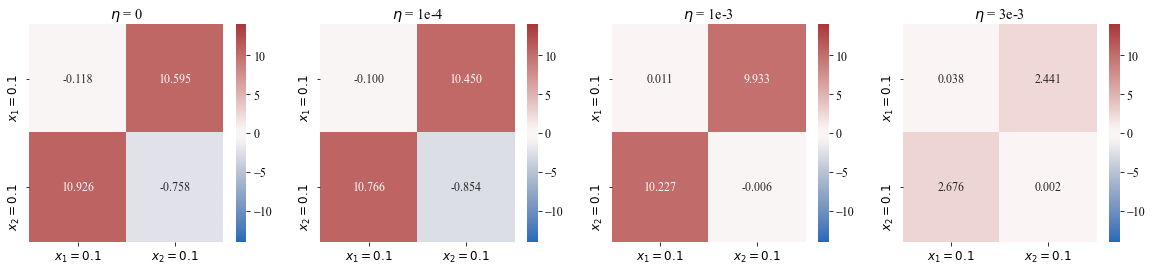

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc("font", family="Times New Roman", size=12)

eta = [0, "1e-4", "1e-3", "3e-3"]
plt.figure(figsize=(20, 4))
for i in range(1, 5):
    ax = plt.subplot(1,4,i)
    heatmap = sns.heatmap(times3(eval("eta_{}_R_state_1".format(i-1))), \
                          cmap="vlag", annot = eval("eta_{}_R_state_1".format(i-1)), \
                          fmt=".3f", cbar=True, vmax=14, vmin=-14, \
                          xticklabels = ['$x_1=0.1$','$x_2=0.1$'], yticklabels = ['$x_1=0.1$','$x_2=0.1$'])
    plt.title("$\eta$ = " + str(eta[i-1]))

# plt.savefig("state_20", dpi=1000)
plt.show()

# $\gamma_{state} = 10$

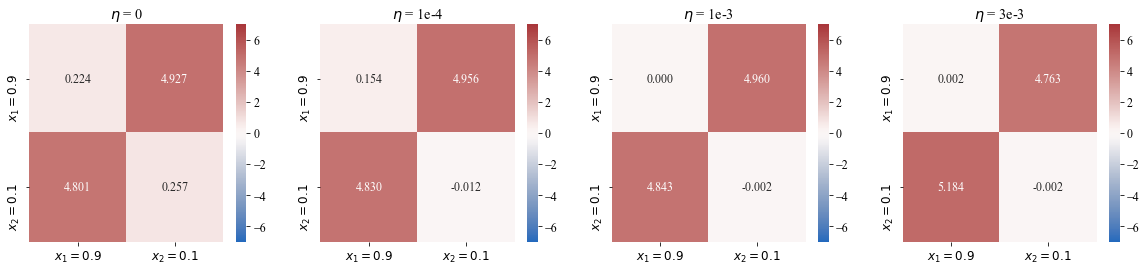

In [30]:
plt.rc("font", family="Times New Roman", size=12)
plt.figure(figsize=(20, 4))
for i in range(1, 5):
    ax = plt.subplot(1,4,i)
    heatmap = sns.heatmap(times3(eval("eta_{}_R_state_3".format(i-1))), \
                          cmap="vlag", annot = eval("eta_{}_R_state_3".format(i-1)), \
                          fmt=".3f", cbar=True, vmax=7, vmin=-7, \
                          xticklabels = ['$x_1=0.9$','$x_2=0.1$'], yticklabels = ['$x_1=0.9$','$x_2=0.1$'])
    plt.title("$\eta$ = " + str(eta[i-1]))

# plt.savefig("state_10", dpi=1000)
plt.show()

# $\gamma_{state} = -10$

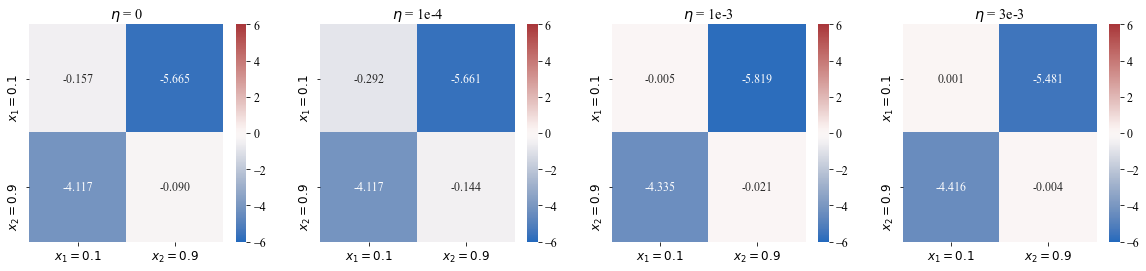

In [31]:
plt.rc("font", family="Times New Roman", size=12)

plt.figure(figsize=(20, 4))
for i in range(1, 5):
    ax = plt.subplot(1,4,i)
    heatmap = sns.heatmap(times3(eval("eta_{}_R_state_2".format(i-1))), \
                          cmap="vlag", annot = eval("eta_{}_R_state_2".format(i-1)), \
                          fmt=".3f", cbar=True, vmax=6, vmin=-6, \
                          xticklabels = ['$x_1=0.1$','$x_2=0.9$'], yticklabels = ['$x_1=0.1$','$x_2=0.9$'])
    plt.title("$\eta$ = " + str(eta[i-1]))

# plt.savefig("state_-10", dpi=1000)
plt.show()

# $\gamma_{state} = -5$

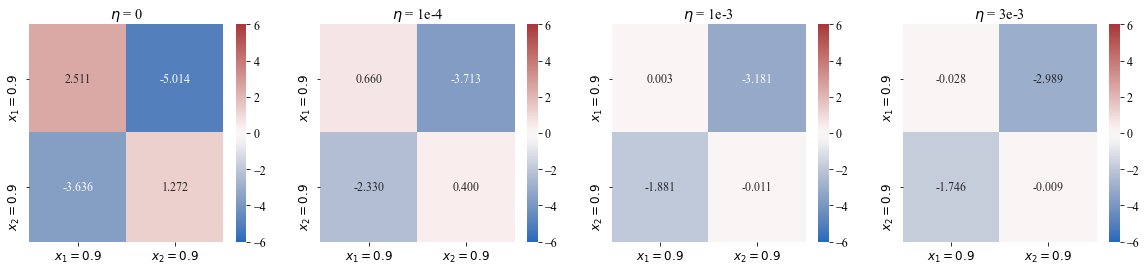

In [32]:
plt.rc("font", family="Times New Roman", size=12)
plt.figure(figsize=(20, 4))
for i in range(1, 5):
    ax = plt.subplot(1,4,i)
    heatmap = sns.heatmap((eval("eta_{}_R_state_4".format(i-1))), \
                          cmap="vlag", annot = eval("eta_{}_R_state_4".format(i-1)), \
                          fmt=".3f", cbar=True, vmax=6, vmin=-6, \
                          xticklabels = ['$x_1=0.9$','$x_2=0.9$'], yticklabels = ['$x_1=0.9$','$x_2=0.9$'])
    plt.title("$\eta$ = " + str(eta[i-1]))

# plt.savefig("state_-5", dpi=1000)
plt.show()

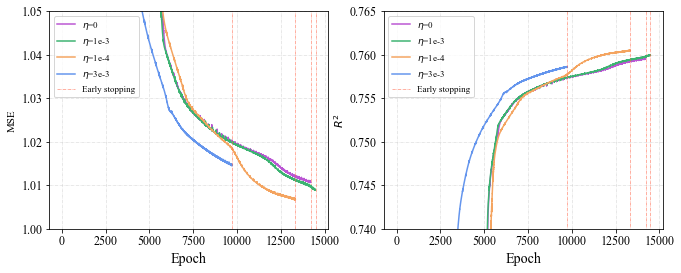

In [33]:
plt.rc("font", family="Times New Roman", size=12)
plt.figure(figsize=(11, 4))

# MSE
ax1 = plt.subplot(1,2,1)
plt.plot(range(len(eta_0_loss_list)), eta_0_loss_list, label = '$\eta$=0', color='mediumorchid')
plt.plot(np.array([len(eta_0_loss_list), len(eta_0_loss_list)]), np.array([1, 1.05]), ls = "-.", linewidth=0.5, color='tomato')
plt.plot(range(len(eta_1_loss_list)), eta_1_loss_list, label = '$\eta$=1e-3', color='mediumseagreen')
plt.plot(np.array([len(eta_1_loss_list), len(eta_1_loss_list)]), np.array([1, 1.05]), ls = "-.", linewidth=0.5, color='tomato')
plt.plot(range(len(eta_2_loss_list)), eta_2_loss_list, label = '$\eta$=1e-4', color='sandybrown')
plt.plot(np.array([len(eta_2_loss_list), len(eta_2_loss_list)]), np.array([1, 1.05]), ls = "-.", linewidth=0.5, color='tomato')
plt.plot(range(len(eta_3_loss_list)), eta_3_loss_list, label = '$\eta$=3e-3', color='cornflowerblue')
plt.plot(np.array([len(eta_3_loss_list), len(eta_3_loss_list)]), np.array([1, 1.05]), ls = "-.", linewidth=0.5, color='tomato', label="Early stopping")
plt.legend(loc='upper left',prop = {'size':9})
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("MSE", fontsize=11)
plt.ylim(1, 1.05)
plt.grid(ls="dashdot", linewidth=0.5, color='lightgray', zorder=0)

# R_2
ax2 = plt.subplot(1,2,2)
plt.ylim(0.74, 0.765)
plt.plot(range(len(eta_0_loss_list)), eta_0_R2_list, label = '$\eta$=0', color='mediumorchid')
plt.plot(np.array([len(eta_0_loss_list), len(eta_0_loss_list)]), np.array([0.7, 0.8]), ls = "-.", linewidth=0.5, color='tomato')
plt.plot(range(len(eta_1_loss_list)), eta_1_R2_list, label = '$\eta$=1e-3', color='mediumseagreen')
plt.plot(np.array([len(eta_1_loss_list), len(eta_1_loss_list)]), np.array([0.7, 0.8]), ls = "-.", linewidth=0.5, color='tomato')
plt.plot(range(len(eta_2_loss_list)), eta_2_R2_list, label = '$\eta$=1e-4', color='sandybrown')
plt.plot(np.array([len(eta_2_loss_list), len(eta_2_loss_list)]), np.array([0.7, 0.8]), ls = "-.", linewidth=0.5, color='tomato')
plt.plot(range(len(eta_3_loss_list)), eta_3_R2_list, label = '$\eta$=3e-3', color='cornflowerblue')
plt.plot(np.array([len(eta_3_loss_list), len(eta_3_loss_list)]), np.array([0.7, 0.8]), ls = "-.", linewidth=0.5, color='tomato', label="Early stopping")
plt.grid(ls="dashdot", linewidth=0.5, color='lightgray', zorder=0)
plt.ylabel("$R^2$", fontsize=11)
plt.legend(loc='upper left',prop = {'size':9})
plt.xlabel("Epoch", fontsize=14)
# plt.savefig("loss", dpi=1000)
plt.show()

In [34]:
# The coefficient of x_1x_2 are obtained by summing the secondary diagonal of R
def get_c(array):
    return array[0][1] + array[1][0]

In [35]:
result = []
for i in np.arange(0.9, -0.1, -0.1):
    for j in np.arange(0, 1, 0.1):
        R = model(torch.tensor([[i, j]],dtype=torch.float32))[1][0].detach().numpy()
        result.append(get_c(R))

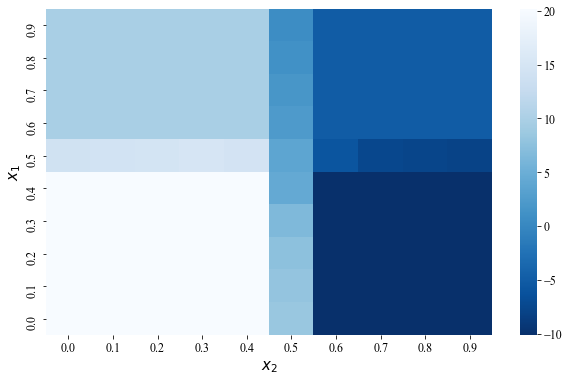

In [36]:
plt.rc('font', family = 'Times New Roman', size = '12')
plt.figure(figsize=(10, 6))
h = sns.heatmap(np.array(result).reshape(10,10), cmap="Blues_r",xticklabels = np.arange(0,10,1) / 10, yticklabels = np.arange(9,-1,-1) / 10, cbar=True)

plt.xlabel("$x_2$", size=15)
plt.ylabel("$x_1$", size=15)
# plt.savefig('TENSOR_1', dpi=500)
plt.show()